In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm

plt.style.use("ggplot")
pyro.set_rng_seed(1209)
np.random.seed(1209)
figsize = (7, 5)


In [15]:
def g(x):
    return -(torch.sin(6 * torch.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


In [16]:
def neg_log_likelihood(x, y, gaussian_process):
    kernel = gaussian_process.kernel
    noise_y = gaussian_process.noise
    n_samples = len(x)
    K = kernel.forward(x)

    # we are using the Cholesky decomposition
    # for the numerical stability of the computation
    # and for performance reasons

    # Compute the Cholesky decomposition
    upper = False
    L = torch.linalg.cholesky(K + noise_y * torch.eye(n_samples), upper=upper)

    alpha = torch.cholesky_solve(y.reshape(-1, 1), L, upper=upper)
    alpha = alpha.squeeze()
    # L being a diagonal matrix has the determinant equal to the sum of the log of
    # the element on the diagonal
    log_det = torch.sum(torch.log(torch.diag(L)))

    # Negative log-likelihood
    NLL = -0.5 * (
        torch.dot(y.T, alpha)
        + log_det
        + n_samples * torch.log(torch.tensor(2.0) * torch.pi)
    )

    return NLL

In [17]:
def neg_likelihood_prior_joint(x, y, gaussian_process, priors, kernel):
    kernel_params = [
        kernel.kern0.lengthscale,
        kernel.kern0.variance,
        kernel.kern1.lengthscale,
        kernel.kern1.variance,
        kernel.kern1.period,
        gaussian_process.noise,
    ]

    neg_likelihood = neg_log_likelihood(x, y, gaussian_process)

    log_prob_prior = torch.tensor(0.0)

    for distribution, value in zip(priors, kernel_params):
        log_prob_prior += distribution.log_prob(value)

    return neg_likelihood - log_prob_prior


## Plot of generating function $g$

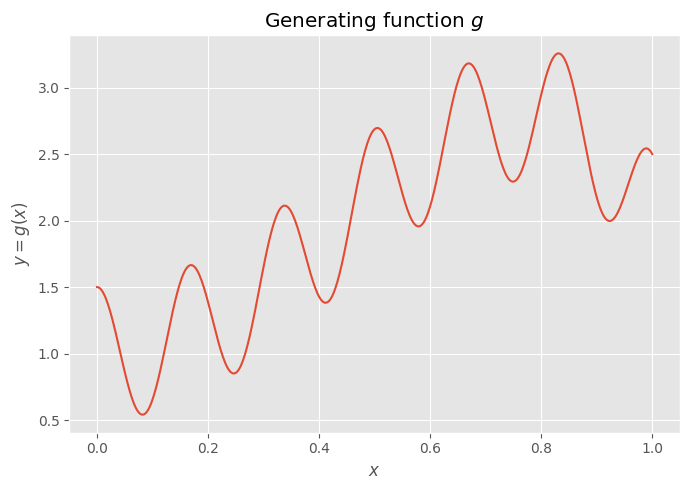

In [18]:
n_points = 500
xs = torch.linspace(0.0, 1.0, n_points)
ys = g(xs)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(xs, ys)
ax.set_title(r"Generating function $g$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y=g(x)$")
plt.tight_layout()
plt.show()


# Training and test data

We assume observations are given by:

$$
y_i = g(x_i) + \epsilon_i, \quad 
$$

where the observations are the grid $x_i = \frac{i-1}{l-1}, i=1,\ldots,l$ with $l=30$.

In [19]:
def generate_data(l=30, split=1.0 / 3.0):
    """
    Generate training and test data for the function g(x) = -(sin(6*pi*x)^2) + 6x^2 - 5x^4 + 3/2.
    :param l: Number of data points.
    :param split: Fraction of data to use as test data.
    :return: x_train, y_train, x_test, y_test
    """
    x = (torch.arange(1, l + 1) - 1) / (l - 1)
    y = g(x) + torch.sqrt(torch.tensor(0.01)) * torch.randn(len(x))

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=split, random_state=3317
    )

    return x_train, y_train, x_test, y_test

In [20]:
x_train, y_train, x_test, y_test = generate_data()

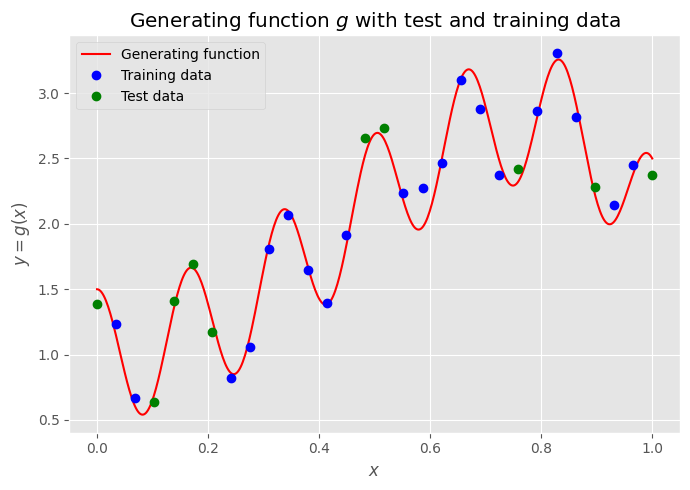

In [21]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(xs, ys, label="Generating function", color="red")
ax.plot(x_train, y_train, "o", label="Training data", color="blue")
ax.plot(x_test, y_test, "o", label="Test data", color="green")
ax.set_title(r"Generating function $g$ with test and training data")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y=g(x)$")
ax.legend()
plt.tight_layout()
plt.show()


## Setup Gaussian kernel

In [22]:
linear = gp.kernels.Linear(input_dim=1, variance=torch.tensor(2.0))


rbf = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(1.0)
)

periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(1 / 6),
    lengthscale=torch.tensor(1.0),
    variance=torch.tensor(1.0),
)

kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)


## Perform GP regression with chosen kernel

Note this is done for a fixed set of kernel parameters.

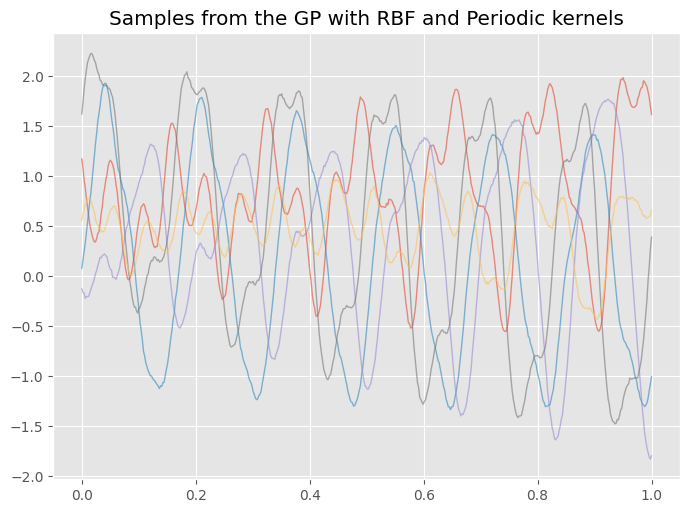

In [23]:
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Samples from the GP
n_samples = 5

cov = kernel.forward(xs)
samples = dist.MultivariateNormal(
    torch.zeros(n_points),
    covariance_matrix=cov + torch.diag(torch.ones(n_points) * 0.0001),
).sample(sample_shape=(n_samples,))

fig, ax = plt.subplots(figsize=figsize)

for sample in samples:
    ax.plot(xs, sample, lw=1, alpha=0.6)

plt.tight_layout()
plt.title("Samples from the GP with RBF and Periodic kernels")
plt.show()


## Plot GP regression (no tuning of hyperparameters)

This is just to visually verify if the model is capable of matching data

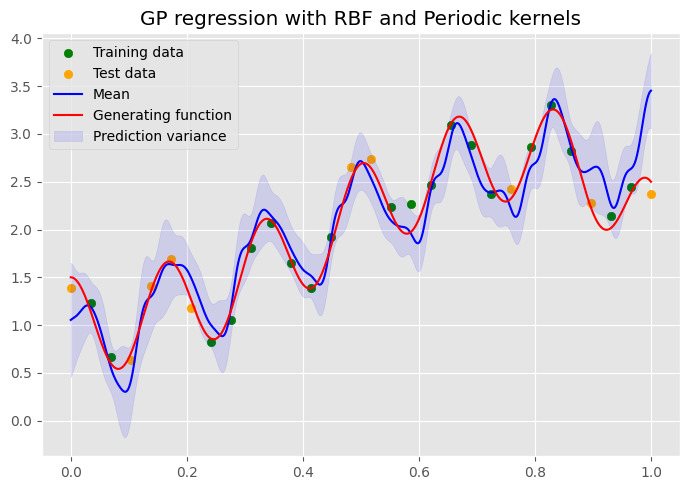

In [24]:
with torch.no_grad():
    mean, cov = gpr(xs, noiseless=False)

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(x_train, y_train, label="Training data", color="green")
ax.scatter(x_test, y_test, label="Test data", color="orange")
ax.plot(xs, mean, label="Mean", color="blue")
ax.plot(xs, ys, label="Generating function", color="red")
ax.fill_between(
    xs,
    mean + torch.sqrt(cov) * 1.95996,
    mean - torch.sqrt(cov) * 1.95996,
    color="blue",
    alpha=0.1,
    label="Prediction variance",
)
ax.set_title("GP regression with RBF and Periodic kernels")
ax.legend()
plt.tight_layout()
# plt.savefig("./figures/gp_regression.png", dpi=600)
plt.show()

In [25]:
mu_noise = 0.01  # Expected noise variance
cv_noise = 1.0  # Coefficient of variation

# Calculate alpha and beta
alpha_noise = (1 / cv_noise) ** 2
beta_noise = alpha_noise / mu_noise
print(f"alpha_noise: {alpha_noise}, beta_noise: {beta_noise}")

alpha_noise: 1.0, beta_noise: 100.0


## Use gradient descent to find optimal hyperparameters $\theta$

In [26]:
# Loss for all iterations
losses = []
# Negative likelihood of the prior joint for all iterations
neg_likelihood_prior_joints_list = []
# list of test log-likelihoods
test_loglikelihoods = []
# list of trained gaussian processes
gaussian_processes = []
# test and training data generated in each iteration
generated_data_sets = []

smoke_test = True
iterations = 20 if not smoke_test else 2

# Priors for the kernel parameters
priors = [  # disse kan defineres udenfor loop
    dist.LogNormal(0.5, 1),  # RBF lengthscale
    dist.LogNormal(0, 1),  # RBF variance
    dist.LogNormal(1.4, 1),  # Periodic lengthscale
    dist.LogNormal(0, 1),  # Periodic variance
    dist.LogNormal(torch.log(torch.tensor(1 / 6)), 0.1),  # Periodic period
    dist.Gamma(alpha_noise, beta_noise),  # noise
]

for i in range(iterations):
    print(f"Iteration {i + 1}/{iterations}")
    pyro.clear_param_store()
    x_train, y_train, x_test, y_test = generate_data()
    generated_data_sets.append((x_train, y_train, x_test, y_test))

    # Defining our kernels and GP-model
    linear = gp.kernels.Linear(input_dim=1, variance=torch.tensor(2.0))

    rbf = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
    )
    periodic = gp.kernels.Periodic(
        input_dim=1,
        period=torch.tensor(1 / 3),
        lengthscale=torch.tensor(1.0),
        variance=torch.tensor(1.0),
    )
    kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)
    # kernel = periodic
    gpr = gp.models.GPRegression(
        x_train, y_train, kernel=kernel, noise=torch.tensor(0.01)
    )

    # Putting priors on our kernel parameters
    # RBF kernel
    gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.5, 1.0))
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    # Periodic kernel
    gpr.kernel.kern1.period = pyro.nn.PyroSample(
        dist.LogNormal(torch.log(torch.tensor(1 / 6)), 0.1)
    )
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(1.4, 1.0))
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.noise = pyro.nn.PyroSample(dist.Gamma(alpha_noise, beta_noise))

    # SVI with delta distribution as guide
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.001)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss  # ToDO er der andre loss fns
    iteration_loss = []
    neg_likelihood_prior_joints = []
    num_steps = 3000
    for i in tqdm(range(num_steps)):
        gpr.set_mode("model")
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        iteration_loss.append(loss.item())

        gpr.set_mode("guide")
        neg_likelihood_prior_joints.append(
            neg_likelihood_prior_joint(x_train, y_train, gpr, priors, kernel)
            .detach()
            .numpy()
        )

    gpr.set_mode("guide")

    losses.append(iteration_loss)
    neg_likelihood_prior_joints_list.append(neg_likelihood_prior_joints)
    test_loglikelihoods.append(neg_log_likelihood(x_test, y_test, gpr))
    gaussian_processes.append(gpr)


Iteration 1/2


100%|██████████| 3000/3000 [00:07<00:00, 405.24it/s]


Iteration 2/2


100%|██████████| 3000/3000 [00:06<00:00, 438.23it/s]


In [27]:
map_test_log_likelihood = [x.detach().item() for x in test_loglikelihoods]
map_test_log_likelihood


[-11.739569664001465, -10.372503280639648]

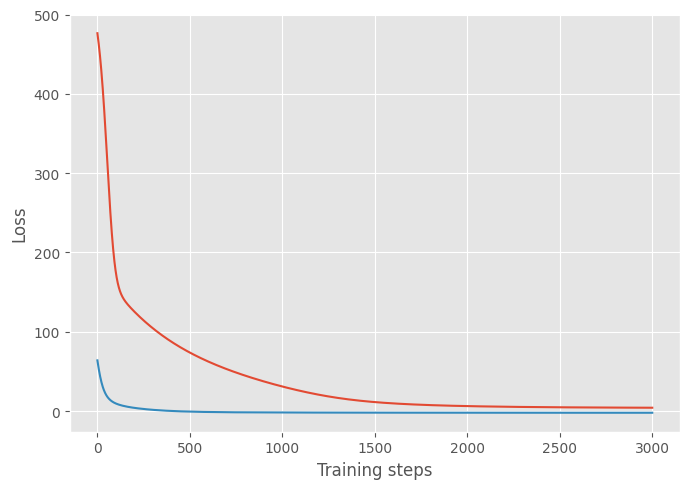

In [28]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_xlabel("Training steps")
ax.set_ylabel("Loss")
for l in losses:
    ax.plot(l)

plt.tight_layout()
plt.show()


In [29]:
def plotfct(generated_data_sets, xs, ys, mean, cov, i):
    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(
        generated_data_sets[i][0],
        generated_data_sets[i][1],
        color="blue",
        label="Train data",
    )  # plot train data
    ax.scatter(
        generated_data_sets[i][2],
        generated_data_sets[i][3],
        color="red",
        label="Test data",
    )  # plot test data
    ax.plot(xs, mean, color="blue", label="Prediction mean")  # plot mean
    ax.plot(xs, ys, color="orange", label=r"$g(x)$")  # plot g(x)
    ax.fill_between(
        xs,
        mean + torch.sqrt(cov) * 1.95,
        mean - torch.sqrt(cov) * 1.95,
        color="blue",
        alpha=0.1,
        label="Prediction variance",
    )  # plot var
    ax.set_title(
        f"GP regression with sum of RBF and Periodic kernels - iteration {i + 1}"
    )
    ax.legend()

    plt.tight_layout()
    # plt.savefig(f"./figures/gp_{i + 1}.png")
    plt.show()

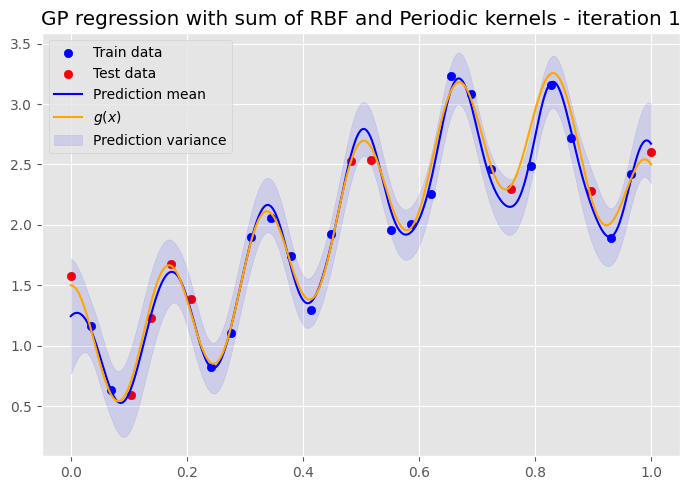

RBF length 0.46035754680633545 var 0.7722840309143066
PERIODIC per 0.16183987259864807 length 3.218524932861328 var 1.392232894897461


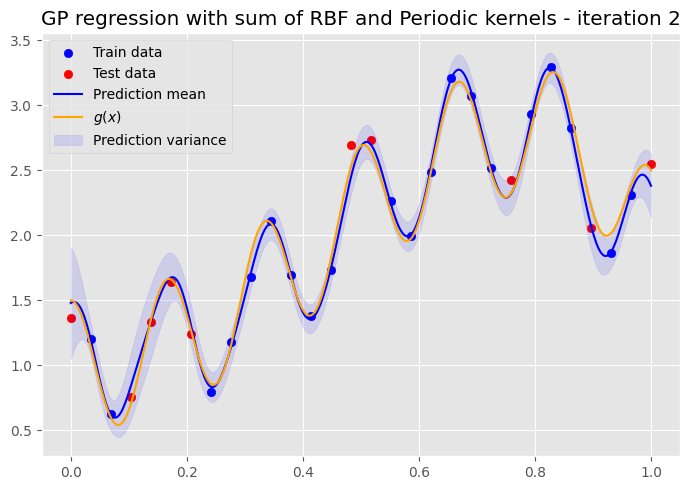

RBF length 0.3916804790496826 var 1.2933158874511719
PERIODIC per 0.16575570404529572 length 3.9250643253326416 var 1.2500553131103516


In [30]:
for i, gp in enumerate(gaussian_processes):
    pyro.clear_param_store()
    gp.set_mode("guide")
    with torch.no_grad():
        mean, cov = gp(xs, noiseless=False)

    plotfct(generated_data_sets, xs, ys, mean, cov, i)

    print(
        f"RBF length {gp.kernel.kern0.lengthscale} var {gp.kernel.kern0.variance}\n"
        f"PERIODIC per {gp.kernel.kern1.period} length {gp.kernel.kern1.lengthscale} var {gp.kernel.kern1.variance}"
    )